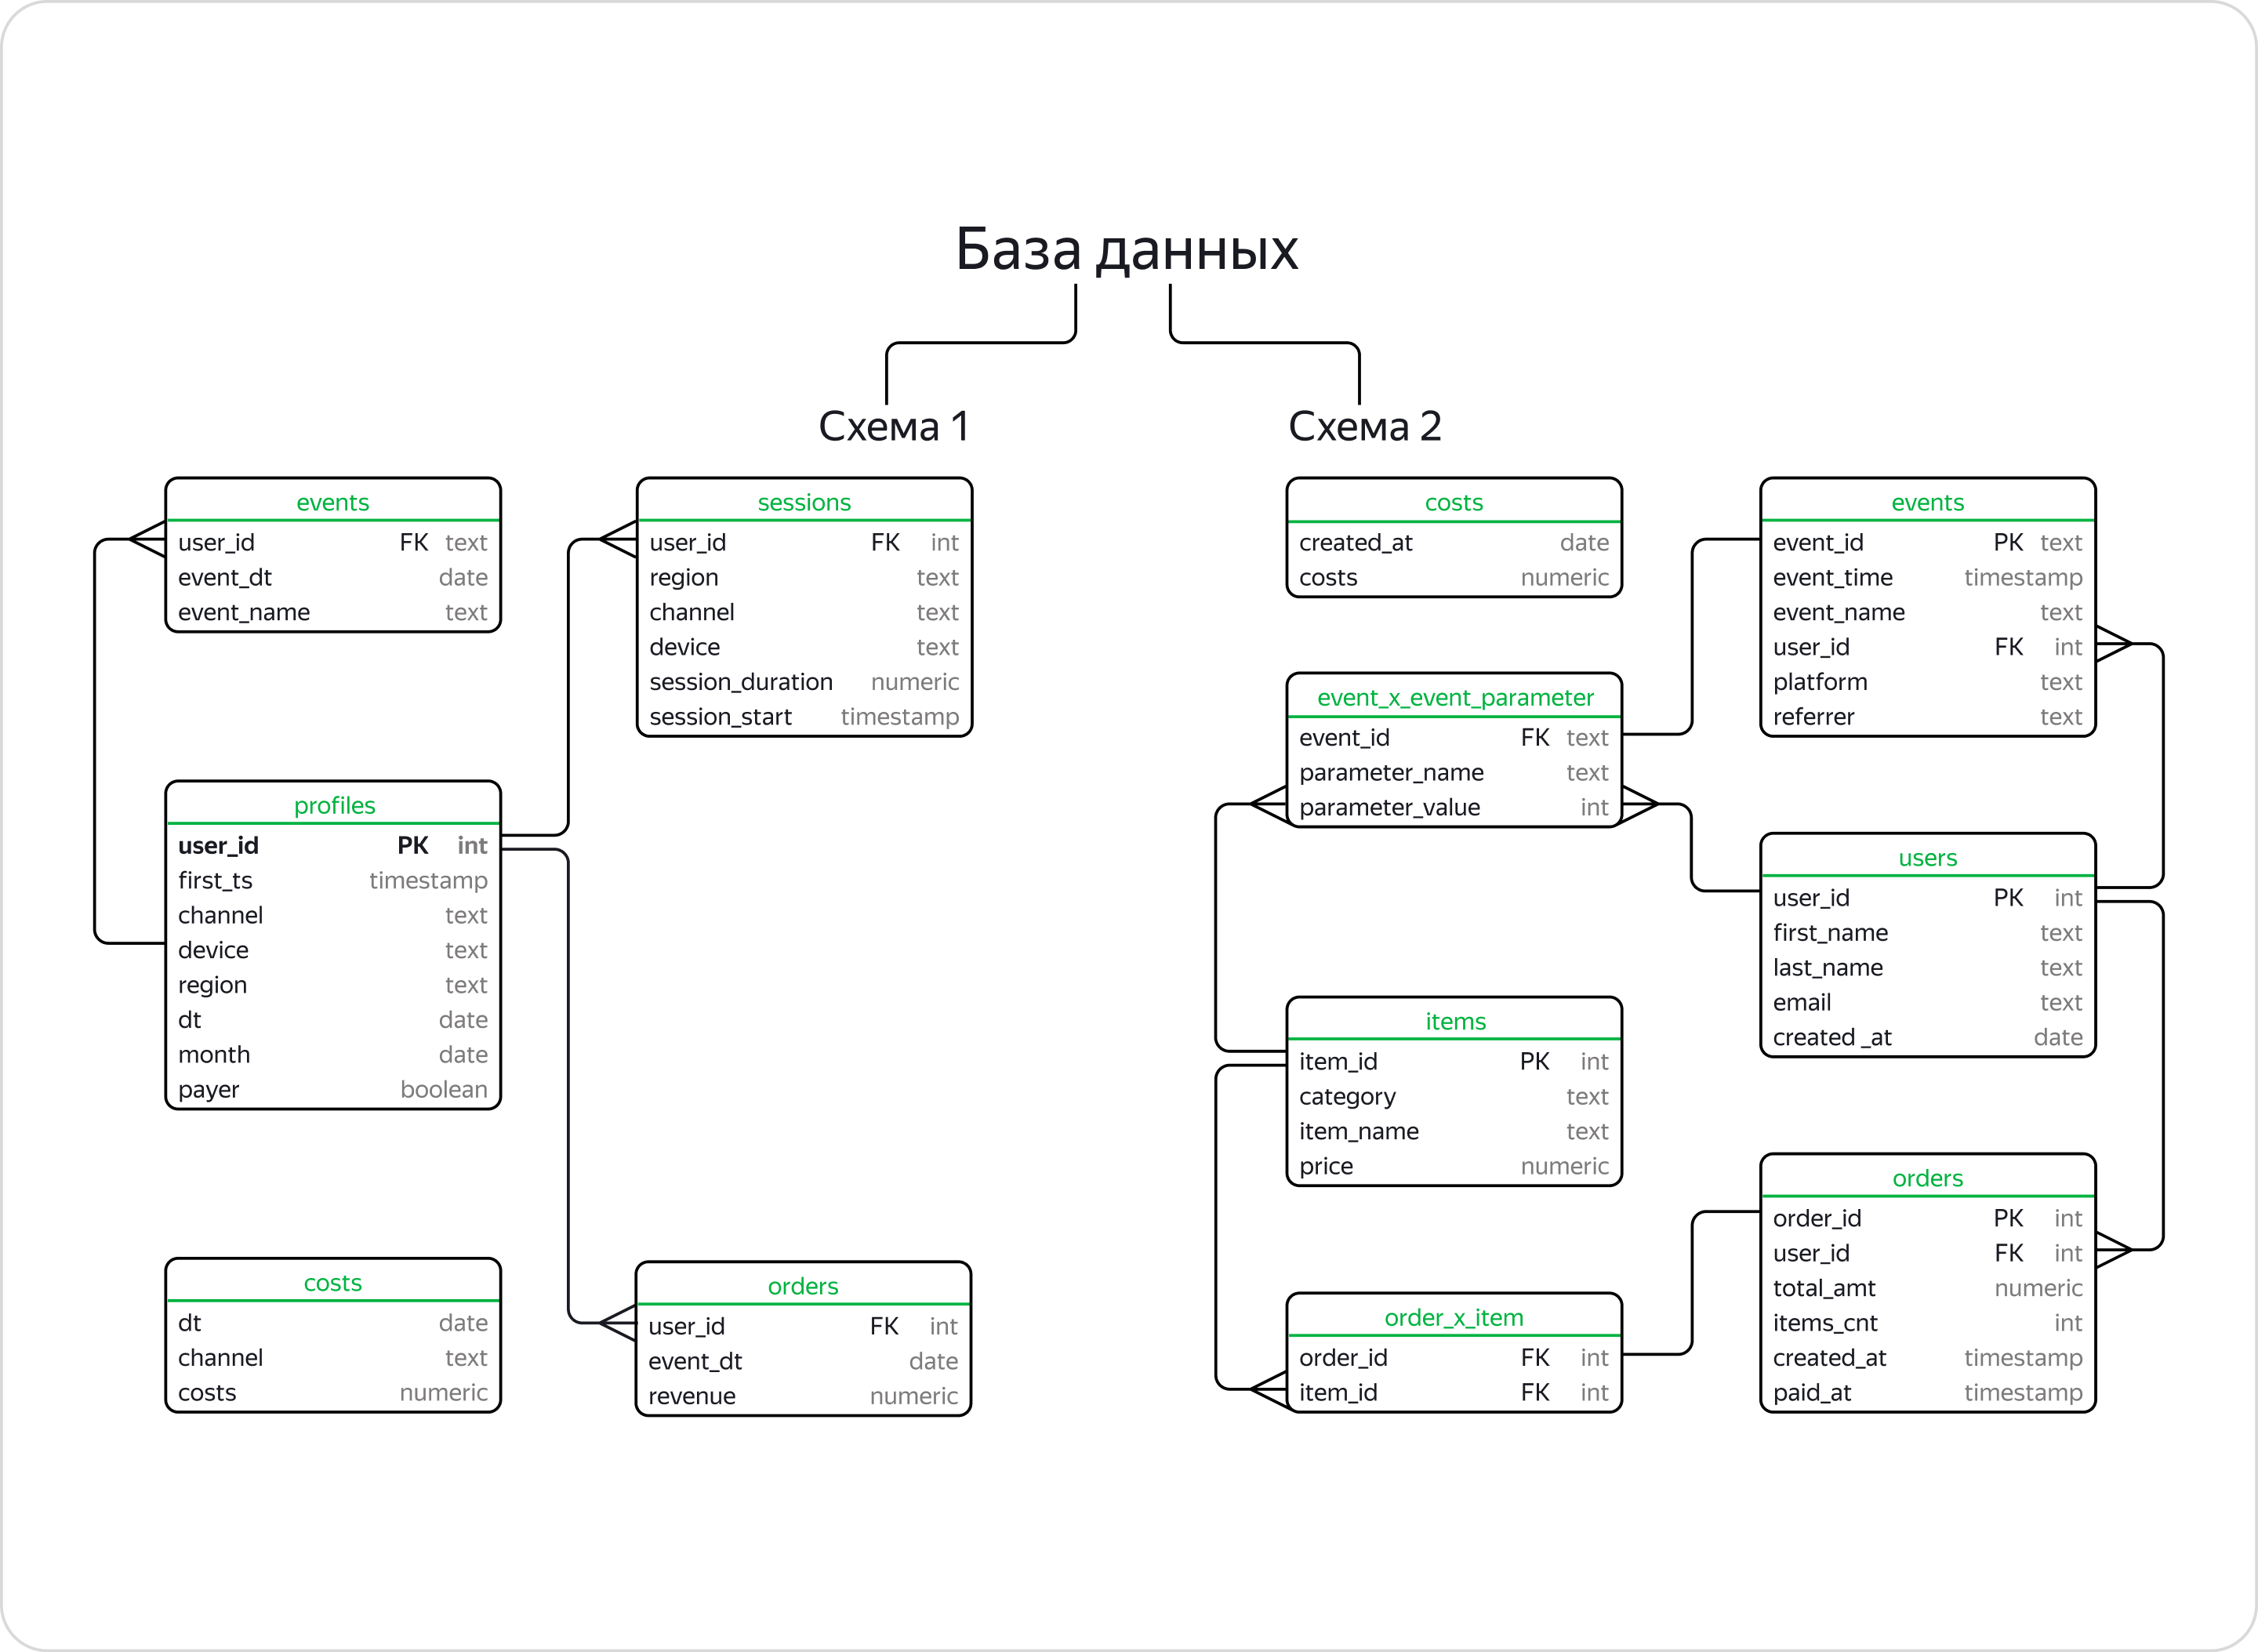

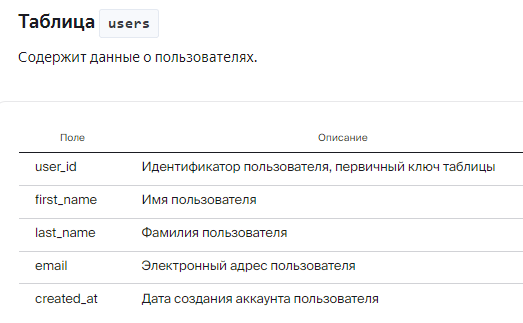

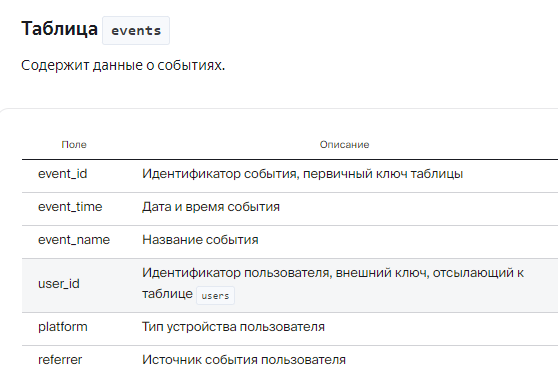

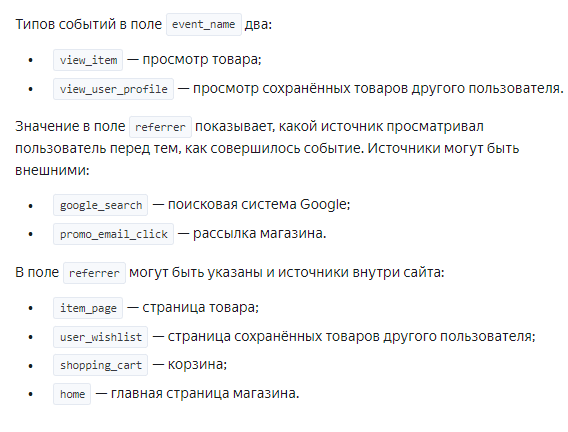

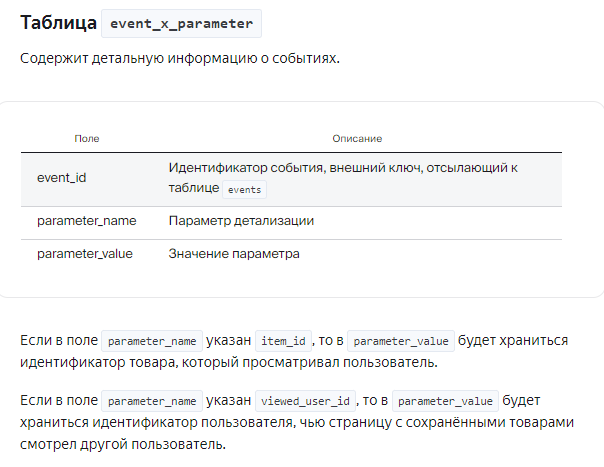

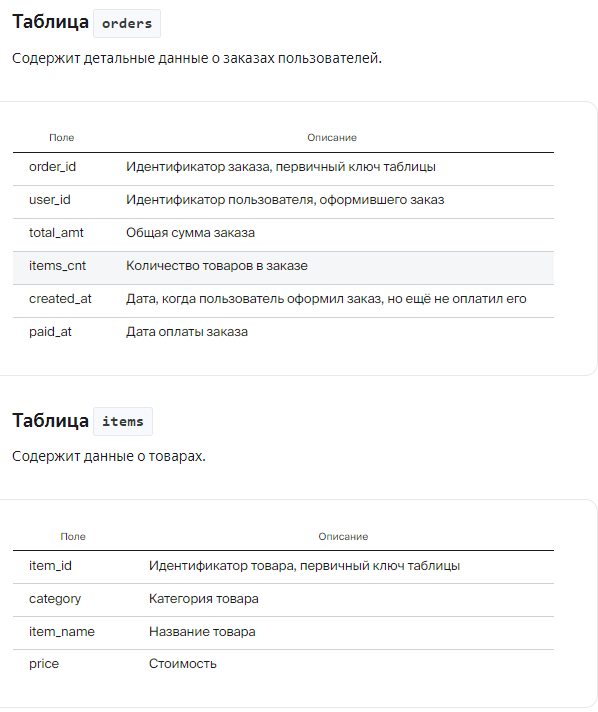

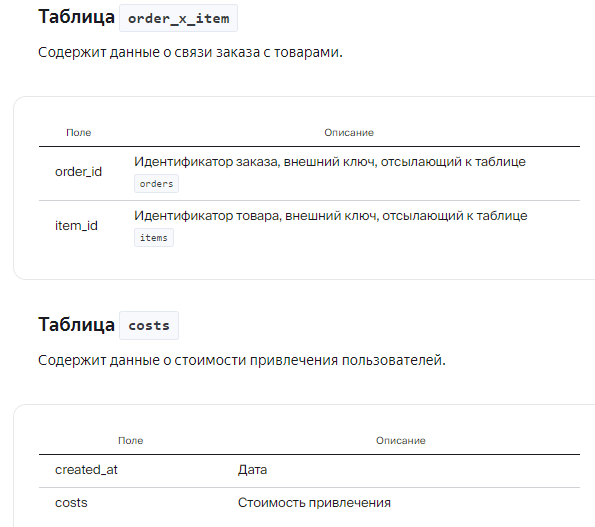

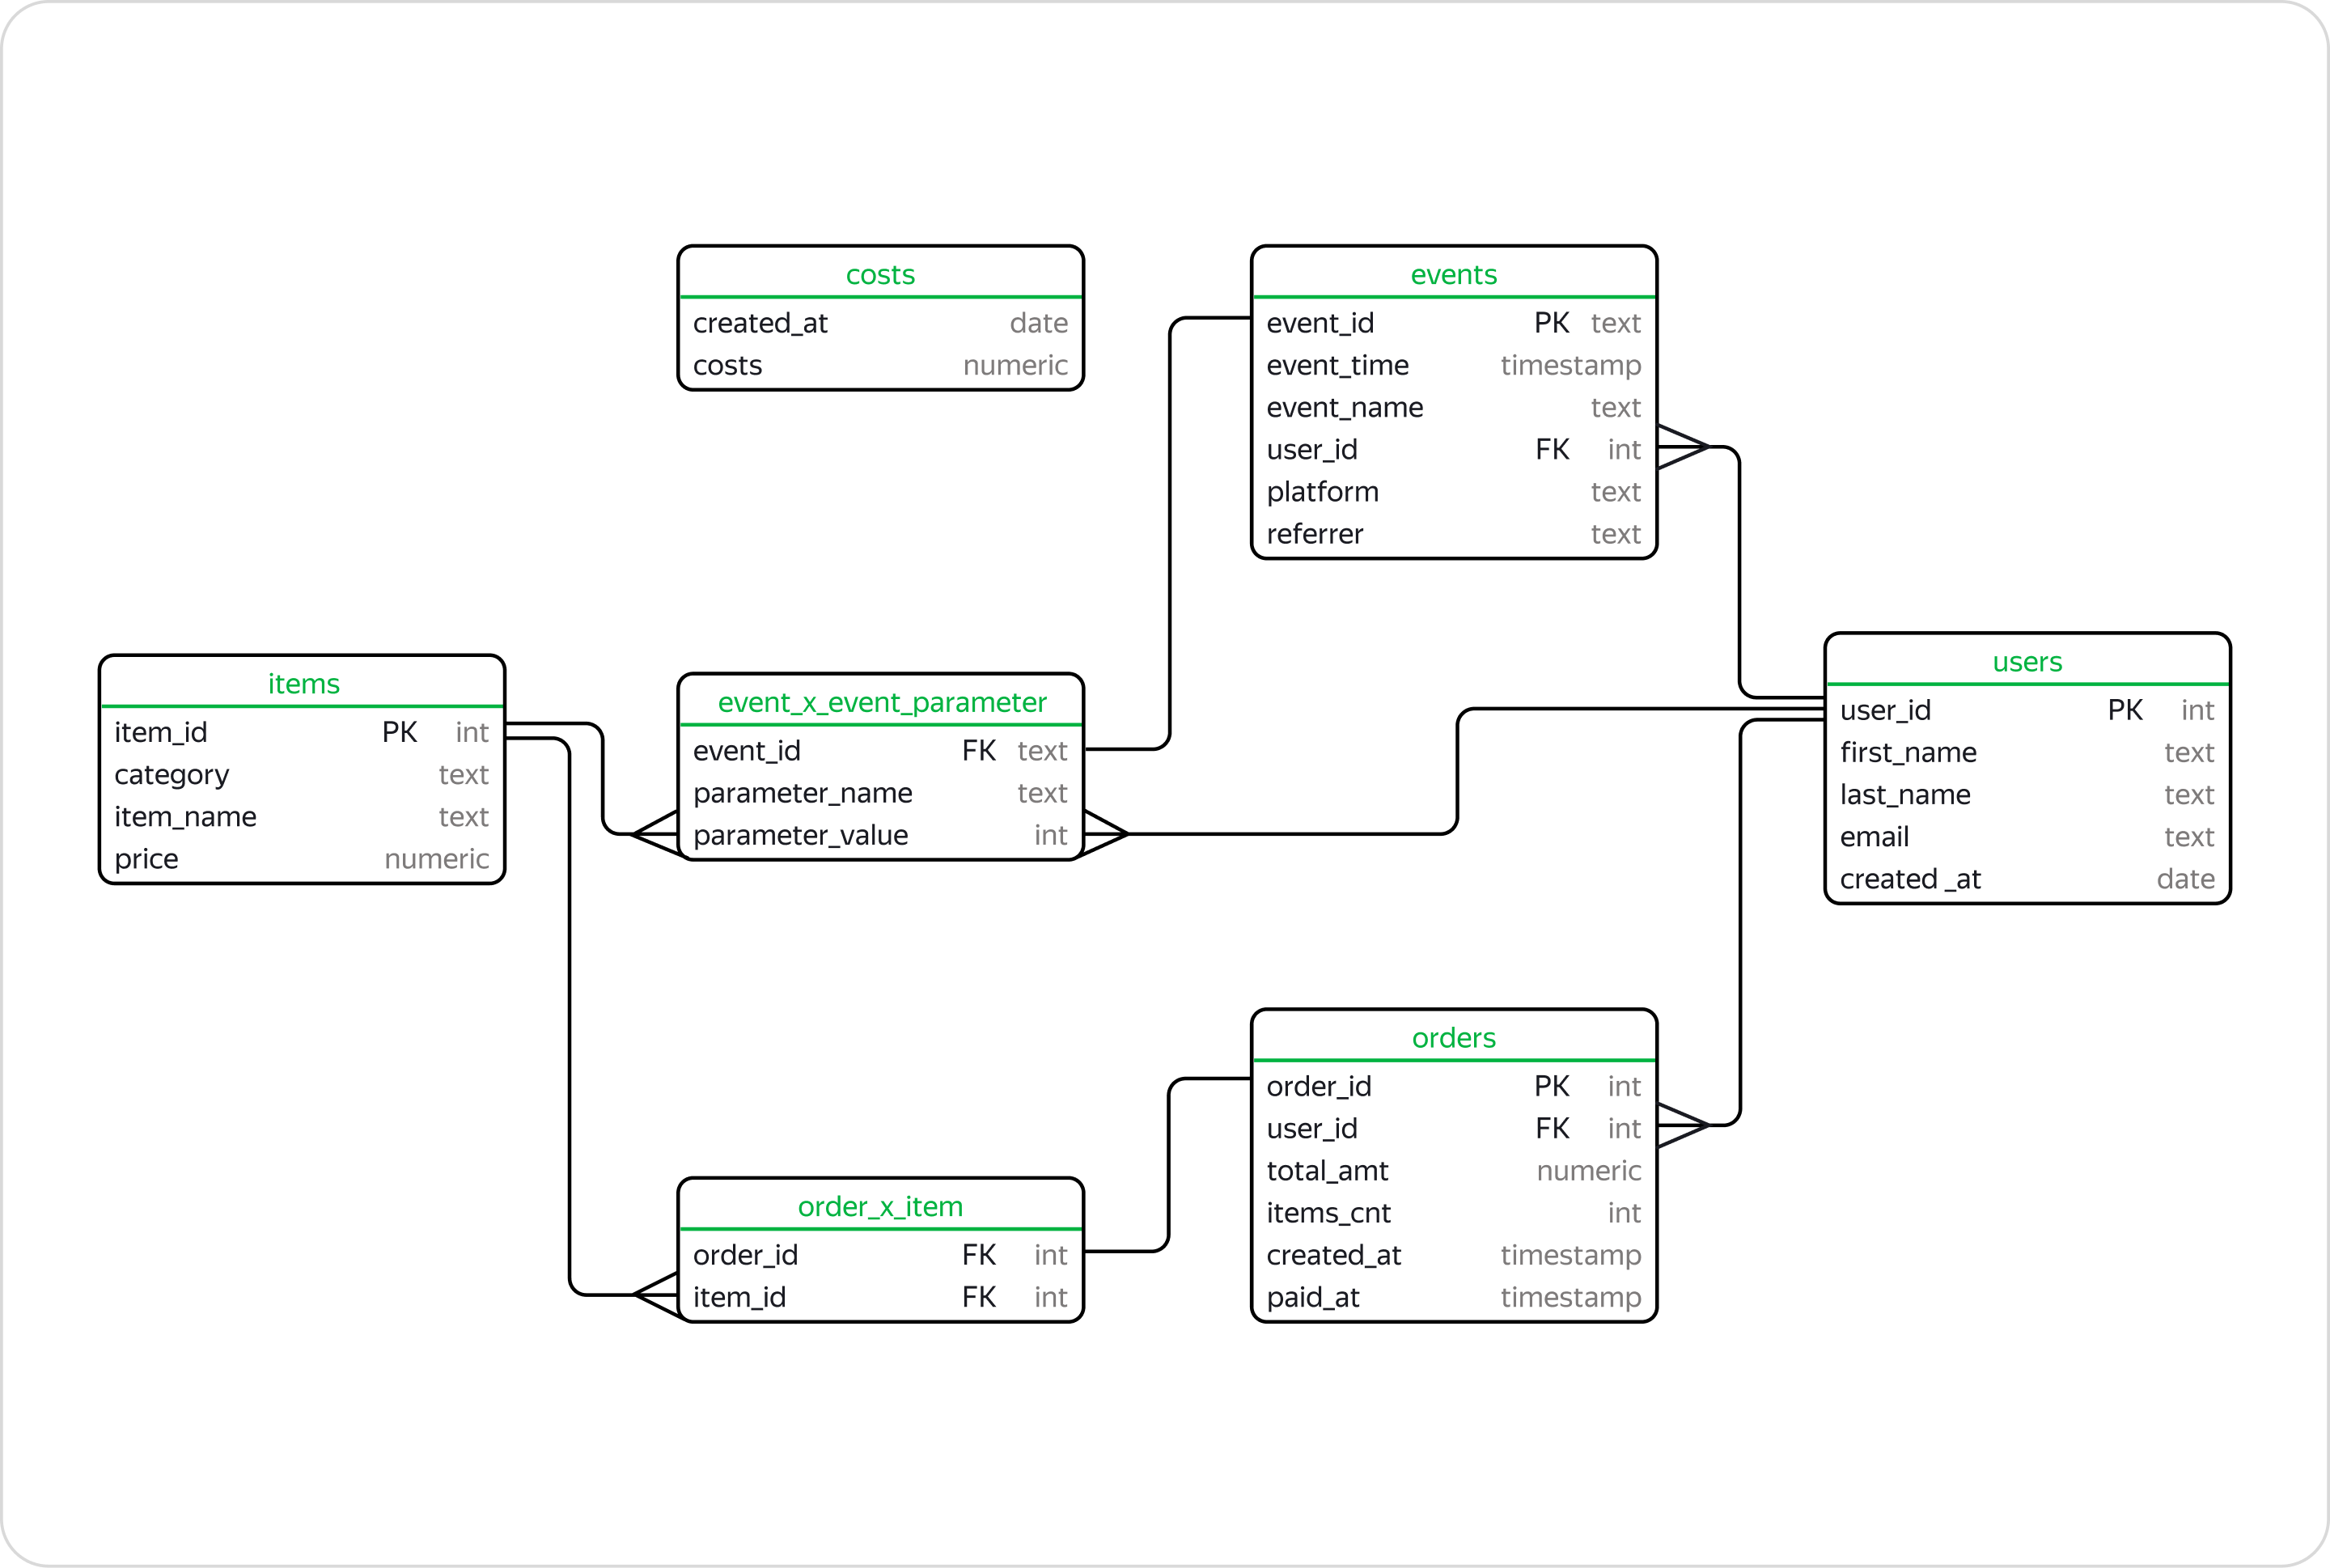

In [ ]:
!pip install sqlalchemy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

In [ ]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

In [ ]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [ ]:
engine = create_engine(connection_string) 

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


**Когортный анализ. Представление результатов: практика**  
Примените знания из предыдущего урока на практике: выгрузите результат SQL-запроса для расчёта Churn Rate в датафрейм и постройте визуализацию. Проанализируйте данные когорт пользователей с января по июнь 2018 года. Визуализировав результат, ответьте на несколько вопросов.

In [ ]:
query = '''
WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS start_mn
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
sessions AS
  (SELECT start_mn,
          DATE_TRUNC('month', event_time)::date AS event_mn,
          COUNT(DISTINCT p.user_id) AS users_cnt
   FROM profile p
   JOIN tools_shop.events e ON p.user_id = e.user_id
   GROUP BY 1,
            2)
SELECT start_mn,
       event_mn,
       users_cnt,
       LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn) AS previous_day_users_cnt,
       ROUND((1 - (users_cnt::numeric / LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn))) * 100, 2) AS churn_rate
FROM sessions
WHERE start_mn BETWEEN '2018-01-01' AND '2018-06-01'
  AND event_mn BETWEEN '2018-01-01' AND '2018-12-01'; 
''' 

In [ ]:
churn_rate_df = pd.read_sql_query(query, con = engine) 

In [ ]:
print(churn_rate_df .head()) 

     start_mn    event_mn  users_cnt  previous_day_users_cnt  churn_rate
0  2018-01-01  2018-01-01        257                     NaN         NaN
1  2018-01-01  2018-02-01         67                   257.0       73.93
2  2018-01-01  2018-03-01         41                    67.0       38.81
3  2018-01-01  2018-04-01         44                    41.0       -7.32
4  2018-01-01  2018-05-01         42                    44.0        4.55


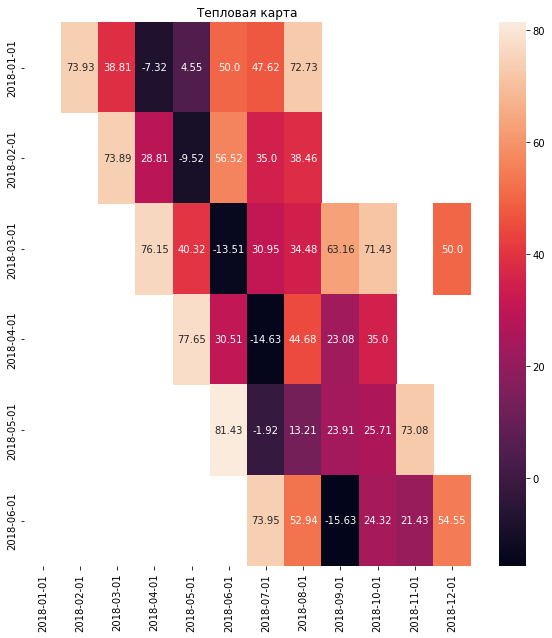

In [ ]:
# создаём сводную таблицу с результатами
churn = churn_rate_df.pivot('start_mn', 'event_mn', 'churn_rate')
churn.index = [str(x)[0:10] for x in churn.index]
churn.columns = [str(x)[0:10] for x in churn.columns]

# строим хитмэп
plt.figure(figsize=(10, 10)) # задаём размер графика
sns.heatmap(churn, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

В какой когорте пользователей самый большой отток в первый месяц? Май 2018 года  
Есть ли такие когорты, в которых нет отрицательного оттока ни в один месяц? НЕТ  
В какой когорте наименьший отток пользователей во второй месяц? Май 2018 года  

In [ ]:
query = '''

EXPLAIN 
SELECT *
FROM online_store.orders; 

''' 

pd.read_sql_query(query, con = engine) 

,QUERY PLAN
0,Seq Scan on orders (cost=0.00..346.67 rows=21...


In [ ]:
query = '''

EXPLAIN 
SELECT user_id, 
             SUM(revenue) AS user_revenue
FROM online_store.orders
GROUP BY user_id; 
''' 

pd.read_sql_query(query, con = engine) 

,QUERY PLAN
0,HashAggregate (cost=452.51..615.82 rows=13065...
1,Group Key: user_id
2,-> Seq Scan on orders (cost=0.00..346.67 r...


In [ ]:
query = '''

EXPLAIN ANALYZE 

SELECT user_id, 
             SUM(revenue) AS user_revenue
FROM online_store.orders
GROUP BY user_id

''' 

pd.read_sql_query(query, con = engine) 

,QUERY PLAN
0,HashAggregate (cost=452.51..615.82 rows=13065...
1,Group Key: user_id
2,-> Seq Scan on orders (cost=0.00..346.67 r...
3,Planning Time: 0.035 ms
4,Execution Time: 12.243 ms


Напишите запрос, который выведет поля order_id, created_at и минимальное значение поля created_at среди текущей и десяти следующих записей для таблицы tools_shop.orders.

In [ ]:
query = '''

SELECT order_id, created_at,
    MIN(created_at) OVER (ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING)
FROM tools_shop.orders;

'''

pd.read_sql_query(query, con = engine)

,order_id,created_at,min
0,118173,2018-03-17 15:52:32,2017-04-21 06:41:25
1,30192,2019-09-05 12:16:55,2016-11-13 11:52:03
2,55001,2019-03-25 15:56:04,2016-11-13 11:52:03
3,395030,2020-03-26 03:25:58,2016-11-13 11:52:03
4,150638,2020-10-18 13:12:20,2016-11-13 11:52:03
...,...,...,...
18966,304697,2020-09-03 14:08:47,2018-07-02 22:50:10
18967,117684,2018-07-02 22:50:10,2018-07-02 22:50:10
18968,157779,2019-10-11 14:24:01,2018-12-14 00:02:01
18969,10032,2018-12-14 00:02:01,2018-12-14 00:02:01


Напишите запрос, который выведет поля order_id, total_amt и среднее значение total_amt на основе трёх предыдущих записей вместе с текущей.

In [ ]:
query = '''

SELECT order_id, total_amt,
    AVG(total_amt) OVER (ROWS BETWEEN 3 PRECEDING AND CURRENT ROW)
FROM tools_shop.orders;

'''

pd.read_sql_query(query, con = engine)

,order_id,total_amt,avg
0,118173,127.60,127.6000
1,30192,252.76,190.1800
2,55001,550.00,310.1200
3,395030,1171.50,525.4650
4,150638,6.36,495.1550
...,...,...,...
18966,304697,27.50,218.3125
18967,117684,112.20,174.0500
18968,157779,78.75,71.8625
18969,10032,341.76,140.0525


Напишите запрос, который выведет поля order_id, user_id, items_cnt и максимальное количество товаров в заказе среди предыдущего, текущего и следующего заказов для каждого пользователя.

In [ ]:
query = '''

SELECT order_id, user_id, items_cnt,
    MAX(items_cnt) OVER (PARTITION BY user_id ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING)
FROM tools_shop.orders;

'''

pd.read_sql_query(query, con = engine)

,order_id,user_id,items_cnt,max
0,32032,17,3,3
1,42407,25,2,2
2,141449,63,3,3
3,45535,65,1,1
4,16854,69,4,4
...,...,...,...,...
18966,228777,295368,1,1
18967,183968,296332,2,2
18968,223455,296584,4,4
18969,113693,296887,4,4


Для каждого заказа в таблице tools_shop.orders посчитайте товары, которые оплатили в последние 24 часа (англ. 24 hours) относительно даты оплаты текущего заказа.  
Выведите поля:  
идентификатор заказа;  
количество товаров в заказе;  
время оплаты;  
количество товаров, оплаченных в последние 24 часа.

In [ ]:
query = '''

SELECT user_id, items_cnt, paid_at,
       SUM(items_cnt) OVER (ORDER BY paid_at RANGE BETWEEN '1 day' PRECEDING AND CURRENT ROW) 
FROM tools_shop.orders; 

'''

pd.read_sql_query(query, con = engine)

,user_id,items_cnt,paid_at,sum
0,145,2,2016-03-14 18:53:11,2
1,211,1,2016-03-27 00:10:43,1
2,219,3,2016-03-29 03:42:24,3
3,277,3,2016-04-07 04:07:09,3
4,694,1,2016-04-13 17:22:30,1
...,...,...,...,...
18966,260863,3,2021-06-03 23:54:29,15
18967,285147,2,2021-06-04 02:02:20,14
18968,259775,4,2021-06-04 09:31:36,13
18969,288105,3,2021-06-04 11:13:12,14


Для каждого пользователя в таблице tools_shop.users посчитайте, сколько регистраций оформили за промежуток между последними 30 днями от текущего дня и следующими 30 днями. 
Выведите поля:  
идентификатор пользователя;  
дата регистрации;  
количество регистраций за указанный период.  

In [ ]:
query = '''

SELECT user_id, created_at,
       COUNT(created_at) OVER (ORDER BY created_at RANGE BETWEEN CURRENT ROW AND '30 day' FOLLOWING) 
FROM tools_shop.users; 

'''
pd.read_sql_query(query, con = engine)

,user_id,created_at,count
0,8,2016-02-18,90
1,31,2016-02-20,104
2,13,2016-02-21,108
3,27,2016-02-22,112
4,10,2016-02-23,118
...,...,...,...
117173,298980,2021-06-01,96
117174,296562,2021-06-01,96
117175,298748,2021-06-01,96
117176,297925,2021-06-01,96


In [ ]:
# С помощью той же функции ROW_NUMBER() можно найти дату первого заказа для каждого пользователя:

query = '''

WITH orders AS
  (SELECT user_id,
          event_dt,
          ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY event_dt) AS rn
   FROM online_store.orders)
SELECT user_id,
       event_dt
FROM orders
WHERE rn = 1;  

'''
pd.read_sql_query(query, con = engine)

,user_id,event_dt
0,10964006,2020-06-26
1,17733464,2020-06-26
2,59432616,2020-06-17
3,77503711,2020-06-20
4,300768196,2020-06-25
...,...,...
13060,999704877895,2020-06-21
13061,999728996602,2020-06-20
13062,999870562940,2020-06-18
13063,999888035696,2020-06-17


In [ ]:
# Похожим образом можно найти дату и время последней сессии для каждого пользователя.

query = '''

WITH sessions AS
  (SELECT user_id,
          session_start,
          ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY session_start DESC) rn
   FROM online_store.sessions)
SELECT user_id,
       session_start
FROM sessions
WHERE rn = 1; 

'''
pd.read_sql_query(query, con = engine)

,user_id,session_start
0,10964006,2020-06-27 04:21:06
1,12358165,2020-06-24 11:01:14
2,12545358,2020-06-19 03:18:30
3,16165560,2020-06-24 08:22:38
4,17733464,2020-06-27 03:18:11
...,...,...
141340,999939571625,2020-06-23 23:13:21
141341,999954663782,2020-06-17 09:57:28
141342,999957797889,2020-06-27 21:54:26
141343,999974288578,2020-06-20 03:42:53


In [ ]:
# С помощью функции LAST_VALUE() можно найти дату и время последней сессии для каждого пользователя:

query = '''

SELECT DISTINCT user_id,
                LAST_VALUE(session_start) OVER (PARTITION BY user_id ORDER BY session_start ROWS BETWEEN CURRENT ROW AND UNBOUNDED FOLLOWING)
FROM online_store.sessions; 

'''
pd.read_sql_query(query, con = engine)

,user_id,last_value
0,10964006,2020-06-27 04:21:06
1,12358165,2020-06-24 11:01:14
2,12545358,2020-06-19 03:18:30
3,16165560,2020-06-24 08:22:38
4,17733464,2020-06-27 03:18:11
...,...,...
141340,999939571625,2020-06-23 23:13:21
141341,999954663782,2020-06-17 09:57:28
141342,999957797889,2020-06-27 21:54:26
141343,999974288578,2020-06-20 03:42:53


In [ ]:
# Функция NTH_VALUE() отыщет в таблице идентификатор 2021-го пользователя в зависимости от даты регистрации:

query = '''

SELECT DISTINCT NTH_VALUE(user_id, 2021) OVER (ORDER BY created_at) AS user_id
FROM tools_shop.users; 

'''
pd.read_sql_query(query, con = engine)

,user_id
0,5009.0
1,NaN


In [ ]:
# Как и в предыдущем случае, рамка в NTH_VALUE() по умолчанию задаётся выражением ROW BETWEEN UNBOUND PRECEDING AND CURRENT ROW, поэтому для первых 2020 записей функция вернёт значение NULL. 
# Чтобы исключить NULL из итоговой таблицы, нужно расширить рамки окна:

query = '''

SELECT DISTINCT NTH_VALUE(user_id, 2021) OVER (ORDER BY created_at ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS user_id
FROM tools_shop.users; 

'''
pd.read_sql_query(query, con = engine)

,user_id
0,5009



Напишите запрос, который выведет все поля таблицы tools_shop.orders и отдельным полем сумму первого заказа для каждого пользователя.

In [ ]:
query = '''

SELECT *,
       FIRST_VALUE(total_amt) OVER (PARTITION BY user_id ORDER BY created_at)
FROM tools_shop.orders; 

'''
pd.read_sql_query(query, con = engine)

,order_id,user_id,total_amt,items_cnt,created_at,paid_at,first_value
0,32032,17,243.00,3,2016-05-24 22:00:27,2016-05-25 08:27:17,243.00
1,42407,25,1.80,2,2016-05-18 21:44:54,2016-05-17 03:11:48,1.80
2,141449,63,585.00,3,2016-07-04 23:19:50,2016-07-07 11:26:45,585.00
3,45535,65,44.50,1,2016-05-11 06:52:32,2016-05-09 10:22:58,44.50
4,16854,69,9.42,4,2016-08-08 09:56:12,2016-08-09 23:25:51,9.42
...,...,...,...,...,...,...,...
18966,228777,295368,45.00,1,2021-05-30 21:15:54,2021-06-01 09:27:57,45.00
18967,183968,296332,4.65,2,2021-05-28 21:34:11,2021-05-29 22:55:55,4.65
18968,223455,296584,8.82,4,2021-06-01 05:27:26,2021-06-02 15:15:39,8.82
18969,113693,296887,144.00,4,2021-05-29 07:40:08,2021-05-29 15:02:38,144.00


Напишите запрос, который выведет все поля таблицы tools_shop.costs и отдельным полем сумму трат в последний день каждого месяца.

In [ ]:
query = '''

SELECT *,
       LAST_VALUE(costs) OVER (PARTITION BY DATE_TRUNC('month', created_at)::date)
FROM tools_shop.costs; 

'''
pd.read_sql_query(query, con = engine)

,created_at,costs,last_value
0,2016-03-12,100.14,15.02
1,2016-03-26,15.43,15.02
2,2016-03-30,15.02,15.02
3,2016-04-05,15.35,27.15
4,2016-04-12,3.60,27.15
...,...,...,...
1814,2021-05-28,2686.34,676.70
1815,2021-05-29,612.10,676.70
1816,2021-05-30,503.47,676.70
1817,2021-05-31,676.70,676.70


Магазин решил устроить розыгрыш и вручить подарок пользователю, который оформил десятитысячный по счёту заказ. Выведите идентификатор такого пользователя.

In [ ]:
query = '''

SELECT DISTINCT NTH_VALUE(user_id, 10000) OVER (ORDER BY created_at ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS user_id
FROM tools_shop.orders; 

'''
pd.read_sql_query(query, con = engine)

,user_id
0,127599


Для каждого заказа из таблицы tools_shop.orders, оплаченного в 2020 году, рассчитайте количество заказанных товаров с накоплением без учёта текущего заказа. Записи отсортируйте по дате оплаты заказа.  
Выведите поля:  
идентификатор заказа;  
сумма заказа;  
дата оплаты заказа;  
количество заказанных товаров с накоплением.  
Тренажёр пока не может проанализировать ваше решение. Чтобы вы могли проверить себя самостоятельно, мы добавили в подсказку код, который нужно поместить в выражение OVER. Откройте подсказку только после того, как напишете своё решение.

In [ ]:
query = '''

SELECT order_id, total_amt, paid_at,
    COUNT(items_cnt) OVER (ORDER BY paid_at ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW EXCLUDE CURRENT ROW)
FROM tools_shop.orders
WHERE EXTRACT(YEAR FROM paid_at::date) = 2020 

'''
pd.read_sql_query(query, con = engine)

,order_id,total_amt,paid_at,count
0,127774,490.50,2020-01-01 00:45:44,0
1,254803,218.94,2020-01-01 04:23:52,1
2,387096,312.50,2020-01-01 07:19:25,2
3,289078,275.00,2020-01-01 09:52:47,3
4,52962,130.00,2020-01-01 09:56:51,4
...,...,...,...,...
5409,62434,275.00,2020-12-31 14:10:39,5409
5410,14097,3.60,2020-12-31 16:03:05,5410
5411,321722,53.33,2020-12-31 17:41:16,5411
5412,228265,353.00,2020-12-31 20:40:33,5412


Для каждой записи в таблице tools_shop.costs рассчитайте средние траты на привлечение пользователей за последние 30 дней.
Тренажёр пока не может проанализировать ваше решение. Чтобы вы могли проверить себя самостоятельно, мы добавили в подсказку код, который нужно поместить в выражение OVER. Откройте подсказку только после того, как напишете своё решение.

In [ ]:
query = '''

SELECT avg(costs) OVER (ORDER BY created_at RANGE BETWEEN '30 days' PRECEDING AND CURRENT ROW EXCLUDE CURRENT ROW) 
FROM tools_shop.costs

'''
pd.read_sql_query(query, con = engine)

,avg
0,NaN
1,100.140000
2,57.785000
3,43.530000
4,15.266667
...,...
1814,1198.838667
1815,1240.464333
1816,1236.513000
1817,1209.926333


Для каждой записи в таблице tools_shop.orders рассчитайте суммарную стоимость заказов за предыдущий и следующий дни.
Выгрузите поля:
идентификатор заказа;
сумма заказа;
дата оформления заказа до оплаты;
суммарная стоимость заказов за предыдущий и следующий дни.
Тренажёр пока не может проанализировать ваше решение. Чтобы вы могли проверить себя самостоятельно, мы добавили в подсказку код, который нужно поместить в выражение OVER. Откройте подсказку только после того, как напишете своё решение.

In [ ]:
query = '''

SELECT order_id, total_amt, created_at,
    sum(total_amt) OVER (ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING EXCLUDE CURRENT ROW) 
FROM tools_shop.orders
'''
pd.read_sql_query(query, con = engine)

,order_id,total_amt,created_at,sum
0,118173,127.60,2018-03-17 15:52:32,252.76
1,30192,252.76,2019-09-05 12:16:55,677.60
2,55001,550.00,2019-03-25 15:56:04,1424.26
3,395030,1171.50,2020-03-26 03:25:58,556.36
4,150638,6.36,2020-10-18 13:12:20,1247.63
...,...,...,...,...
18966,304697,27.50,2020-09-03 14:08:47,181.20
18967,117684,112.20,2018-07-02 22:50:10,106.25
18968,157779,78.75,2019-10-11 14:24:01,453.96
18969,10032,341.76,2018-12-14 00:02:01,127.15


In [ ]:
# or

query = '''

SELECT order_id, total_amt, created_at,
    sum(total_amt) OVER (ORDER BY created_at::date RANGE BETWEEN '1 day' PRECEDING AND '1 day' FOLLOWING EXCLUDE GROUP) 
FROM tools_shop.orders
'''
pd.read_sql_query(query, con = engine)

,order_id,total_amt,created_at,sum
0,280567,387.50,2016-03-12 05:53:55,NaN
1,324983,48.40,2016-03-26 22:43:41,NaN
2,278543,64.50,2016-03-30 06:58:01,NaN
3,127316,41.10,2016-04-05 04:44:23,NaN
4,342157,13.50,2016-04-12 11:00:39,NaN
...,...,...,...,...
18966,108052,282.00,2021-06-01 15:54:21,2546.33
18967,373935,82.80,2021-06-01 19:00:33,2546.33
18968,235450,12.50,2021-06-01 21:31:19,2546.33
18969,104604,18.00,2021-06-01 08:26:11,2546.33


Напишите запрос, который рассчитает среднюю стоимость привлечения пользователей за последние 30 дней для таблицы tools_shop.costs.  
Выгрузите поля:  
дата, приведённая к типу date;  
стоимость привлечения пользователей в текущий день;  
средняя стоимость привлечения пользователей за последние 30 дней, не включая текущий.  
Тренажёр пока не может проанализировать ваше решение. Чтобы вы могли проверить себя самостоятельно, мы добавили в подсказку код, который нужно поместить в выражение OVER. Откройте подсказку только после того, как напишете своё решение.

In [ ]:
query = '''

SELECT created_at :: date,
    SUM(costs) OVER (ORDER BY created_at), 
    AVG(costs) OVER (ORDER BY created_at RANGE BETWEEN '30 days' PRECEDING AND CURRENT ROW EXCLUDE CURRENT ROW)
FROM tools_shop.costs; 

'''
pd.read_sql_query(query, con = engine)

,created_at,sum,avg
0,2016-03-12,100.14,NaN
1,2016-03-26,115.57,100.140000
2,2016-03-30,130.59,57.785000
3,2016-04-05,145.94,43.530000
4,2016-04-12,149.54,15.266667
...,...,...,...
1814,2021-05-28,1444455.60,1198.838667
1815,2021-05-29,1445067.70,1240.464333
1816,2021-05-30,1445571.17,1236.513000
1817,2021-05-31,1446247.87,1209.926333


Напишите запрос, который рассчитает скользящее среднее время между событиями пользователей за последние семь дней. Для расчёта среднего оставьте только те события, разница между которыми составляет не больше 30 дней.  
Выгрузите поля:  
дата события, приведённая к типу date;  
среднее время между событиями пользователей за последние 30 дней.  
Выведите первые 5000 записей.  
Тренажёр пока не может проанализировать ваше решение. Чтобы вы могли проверить себя самостоятельно, мы добавили в подсказку код, который нужно поместить в выражение OVER. Откройте подсказку только после того, как напишете своё решение.

In [ ]:
query = '''

SELECT event_dt,
       AVG(time_diff) OVER (ORDER BY event_dt RANGE BETWEEN '7 days' PRECEDING AND CURRENT ROW EXCLUDE GROUP)
FROM
  (SELECT event_dt,
          time_diff
   FROM
     (SELECT user_id,
             event_time::date AS event_dt,
             LAG(event_time) OVER (PARTITION BY user_id ORDER BY event_time) AS previous_event_dt,
             event_time - LAG(event_time) OVER (PARTITION BY user_id ORDER BY event_time) AS time_diff
      FROM tools_shop.events) events
   WHERE time_diff <= '30 days' ) time_diff
LIMIT 5000; 

'''
pd.read_sql_query(query, con = engine)

,event_dt,avg
0,2016-03-10,NaT
1,2016-03-11,0 days 09:39:00
2,2016-03-11,0 days 09:39:00
3,2016-03-11,0 days 09:39:00
4,2016-03-13,0 days 17:12:30
...,...,...
4995,2017-01-06,1 days 15:16:44.058219
4996,2017-01-06,1 days 15:16:44.058219
4997,2017-01-06,1 days 15:16:44.058219
4998,2017-01-06,1 days 15:16:44.058219


https://pastebin.com/72Mf2pB0

Напишите запрос, который для каждой записи таблицы tools_shop.orders рассчитает средний чек заказов, оформленных за последние 90 дней.
Выгрузите поля:
идентификатор заказа;
сумма заказа;
средняя сумма заказа за последние 90 дней, не включая текущий.
Тренажёр пока не может проанализировать ваше решение. Чтобы вы могли проверить себя самостоятельно, мы добавили в подсказку код, который нужно поместить в выражение OVER. Откройте подсказку только после того, как напишете своё решение.

In [ ]:
query = '''

SELECT order_id, total_amt,
    AVG(total_amt) OVER (ORDER BY created_at RANGE BETWEEN '90 days' PRECEDING AND CURRENT ROW EXCLUDE GROUP) AS avg_costs
FROM tools_shop.orders

'''
pd.read_sql_query(query, con = engine)

,order_id,total_amt,avg_costs
0,280567,387.50,NaN
1,324983,48.40,387.500000
2,278543,64.50,217.950000
3,127316,41.10,166.800000
4,342157,13.50,135.375000
...,...,...,...
18966,373935,82.80,251.454091
18967,105983,145.96,251.593193
18968,235450,12.50,251.521480
18969,67435,432.50,251.153902


**Описание данных**  
Проект состоит из двух частей:  
В первой части вы решите несколько задач в SQL-тренажёре, чтобы закрепить пройденный материал.  
Вторая часть проекта — аналитическая. Проверять задачи по-прежнему будет тренажёр. Однако мы рекомендуем самостоятельно анализировать полученные результаты и формулировать выводы.  
Внимательно читайте условия. Формулировки задач в проекте приближены к реальной жизни. В работе часто встретятся такие формулировки: «рассчитать LTV за последние 30 дней», «отобразить самых активных покупателей» или даже «определить, почему в компании упали продажи».  
В самостоятельном проекте вы будете работать с базой данных StackOverflow — сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.
Вы будете работать с версией базы, где хранятся данные о постах за 2008 год, но в таблицах вы найдёте информацию и о более поздних оценках, которые эти посты получили.  
Изучите ER-диаграмму базы:  


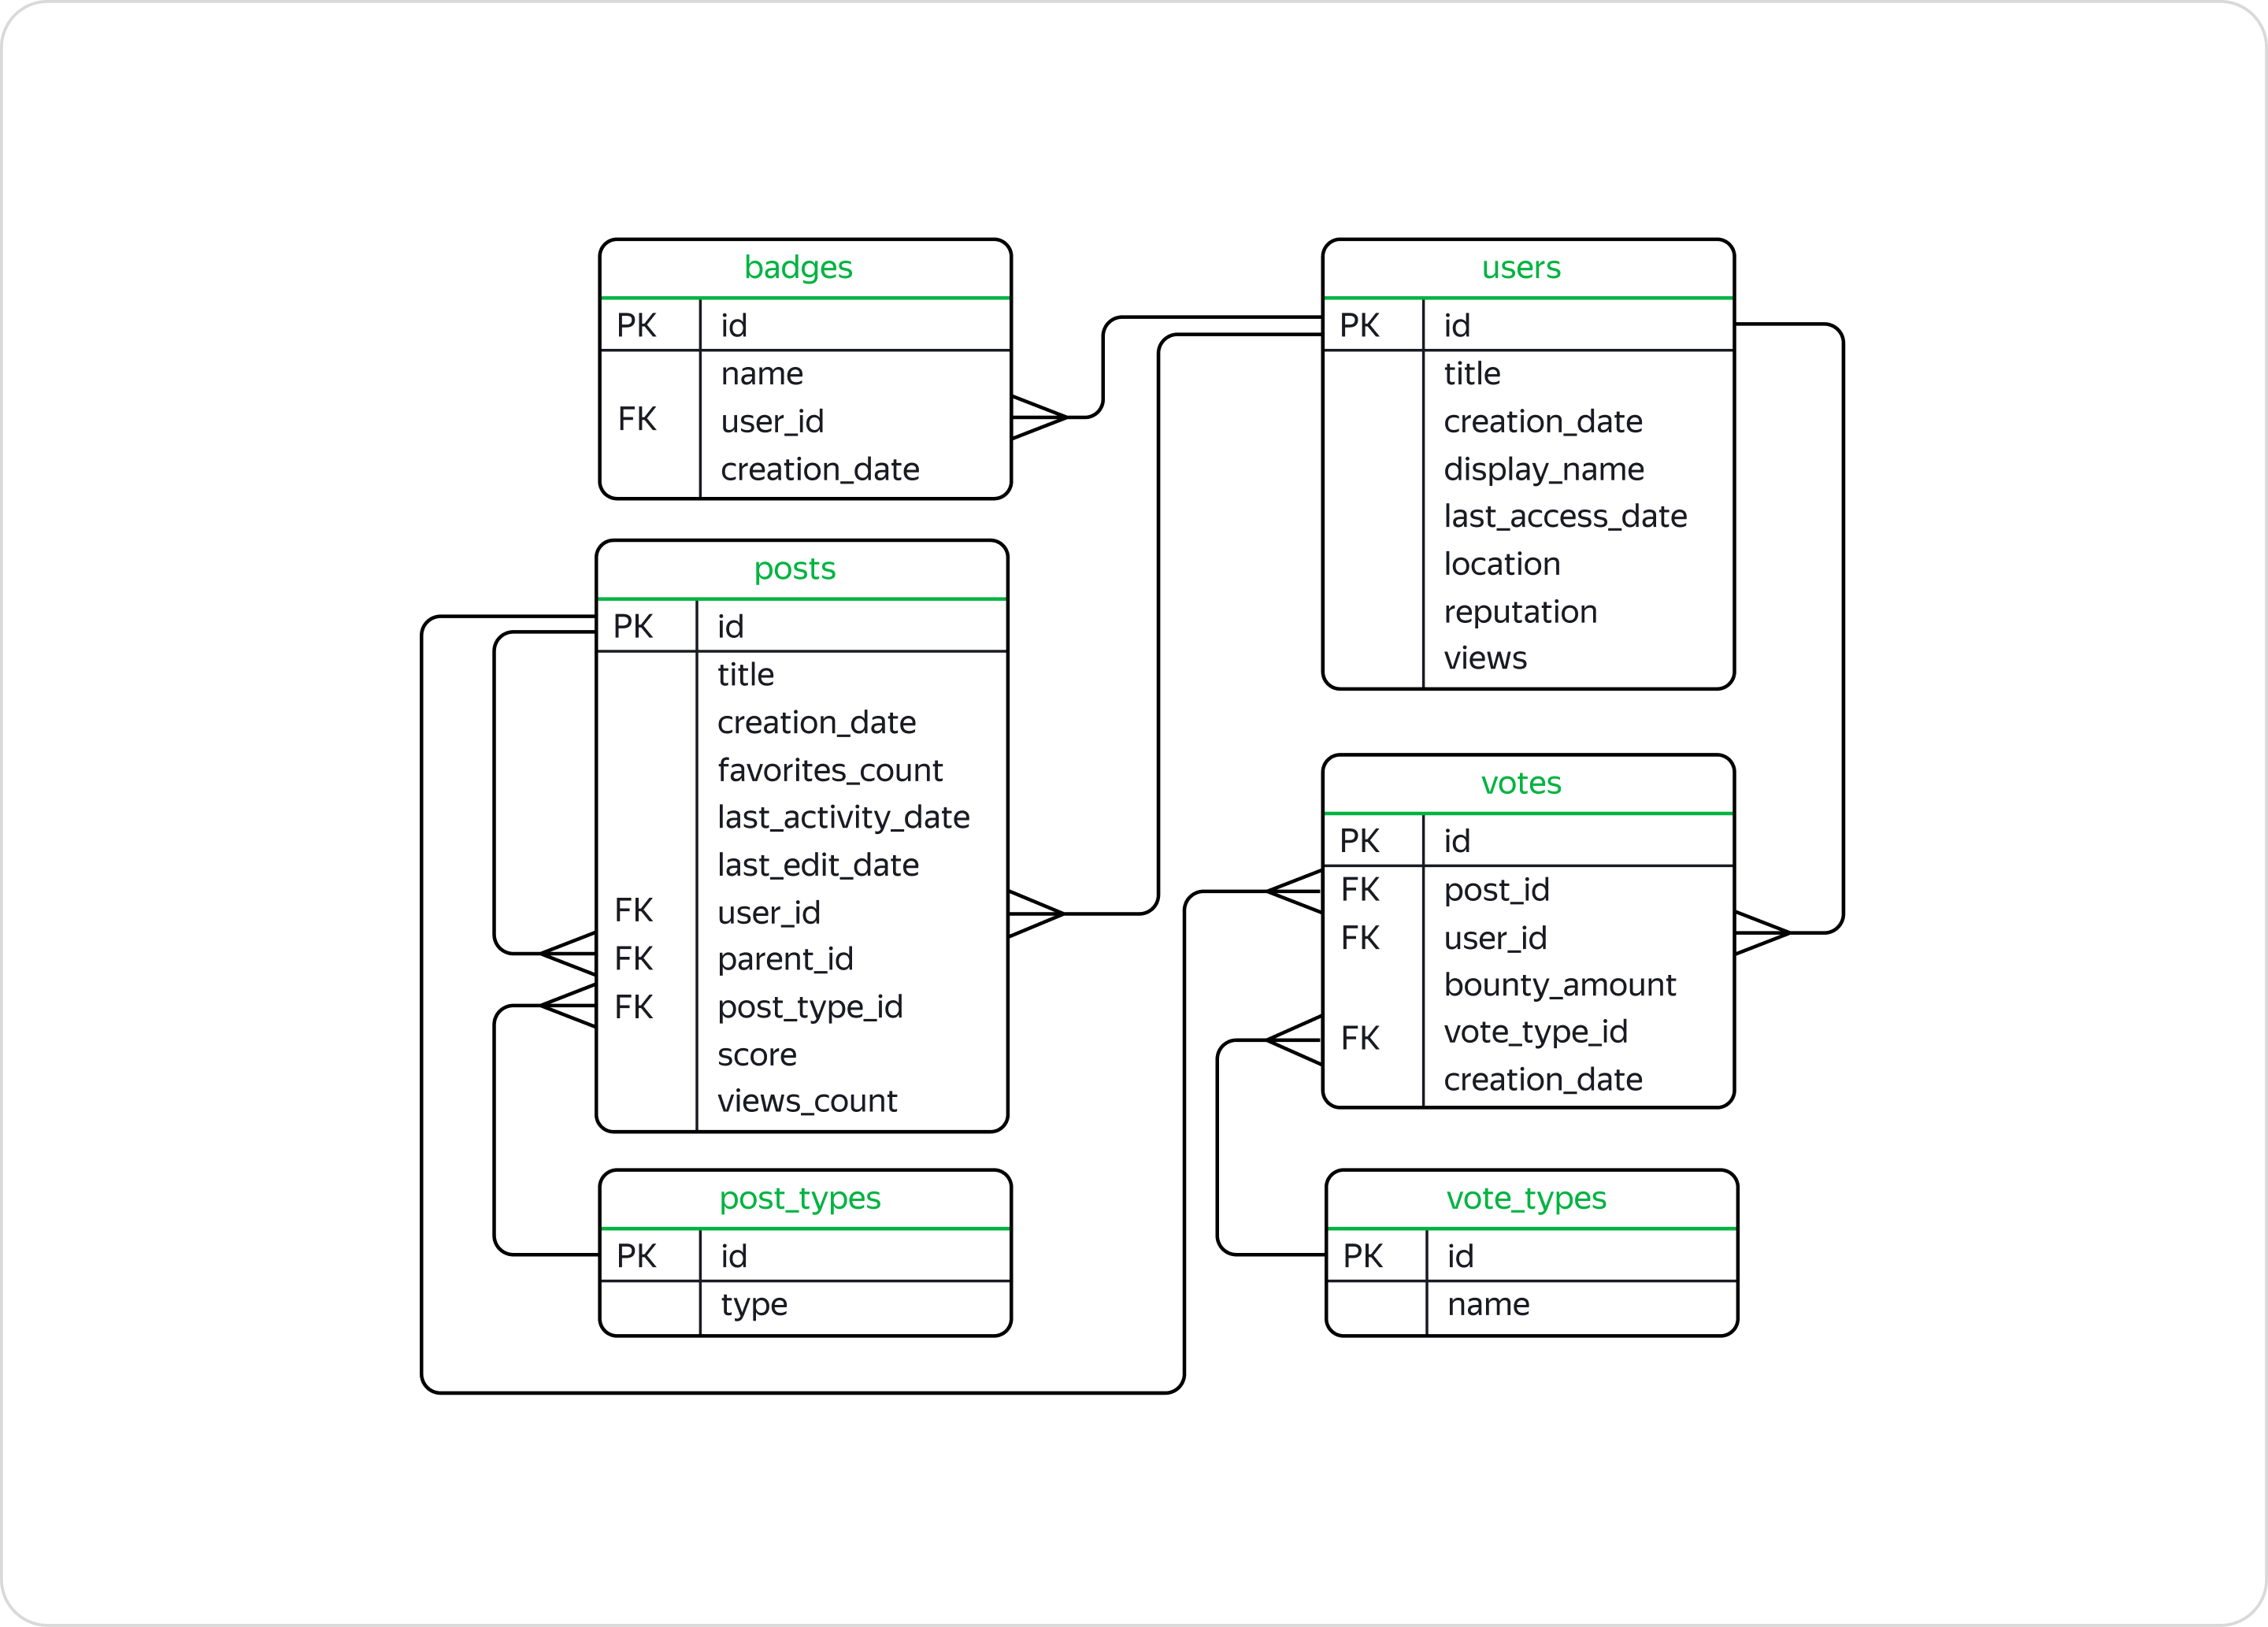

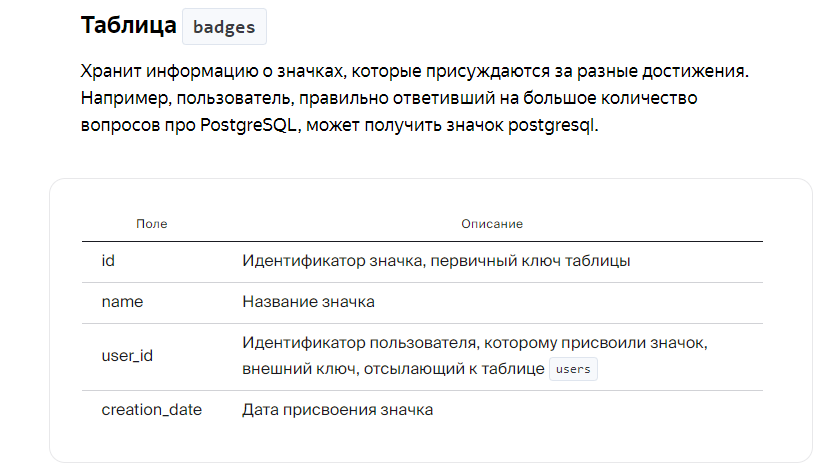

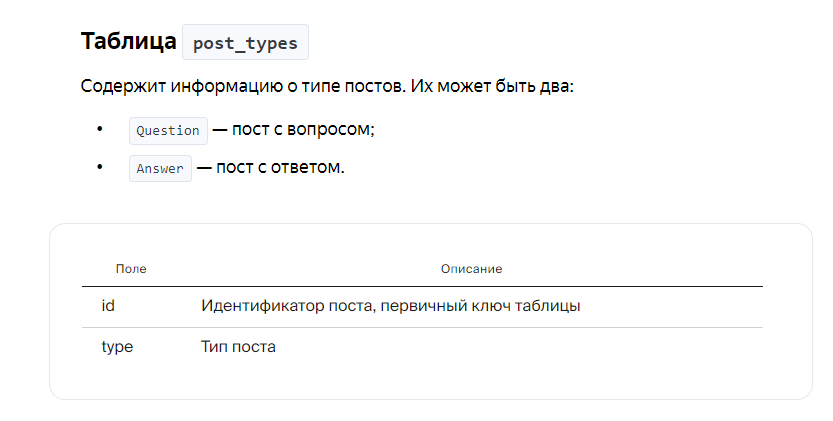

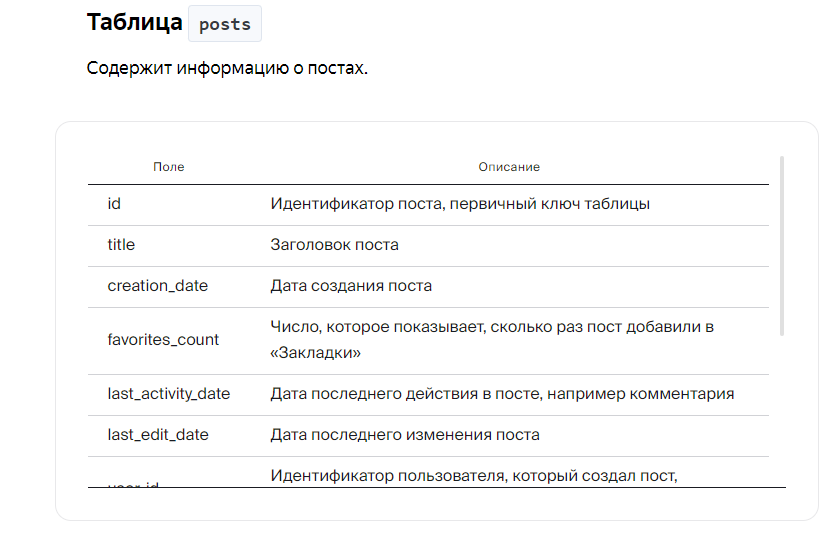

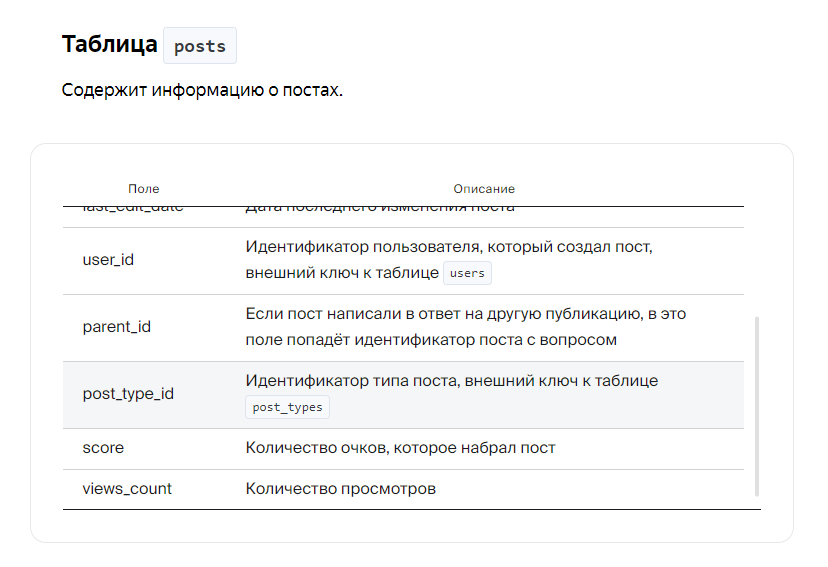

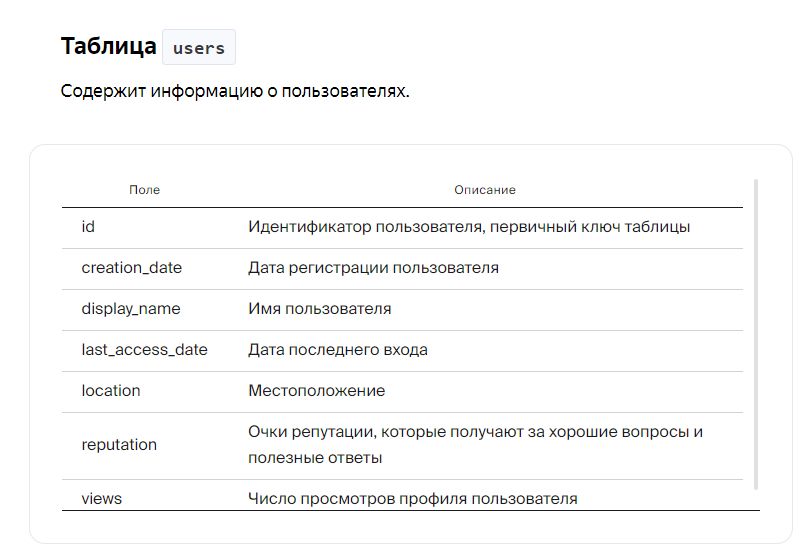

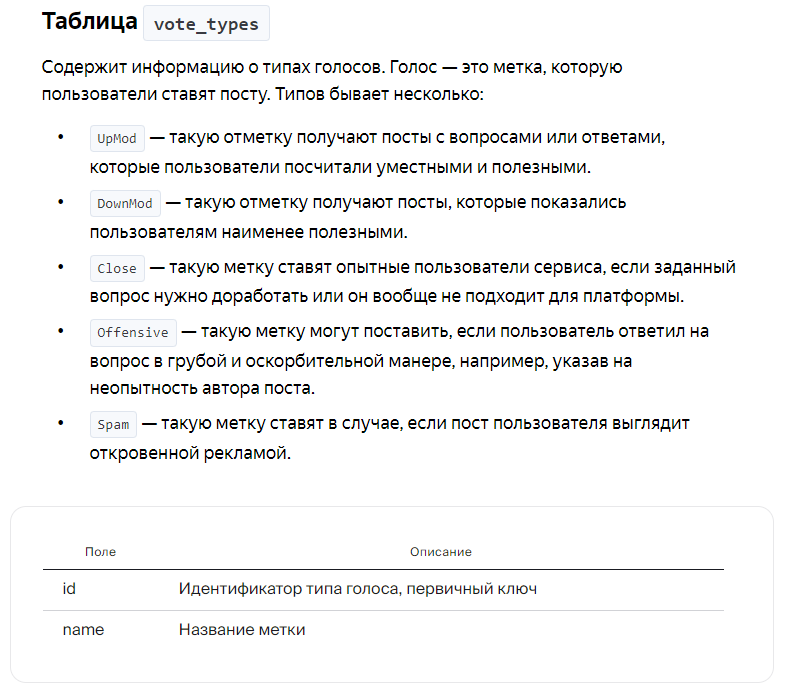

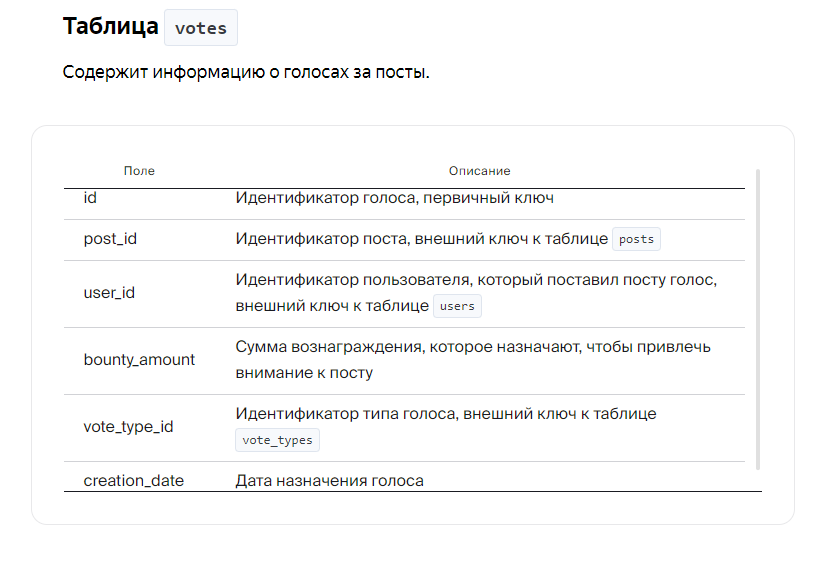

In [ ]:
#query = '''

#'''
#pd.read_sql_query(query, con = engine)

Найдите количество вопросов, которые набрали больше 300 очков или как минимум 100 раз были добавлены в «Закладки».

In [ ]:
query = '''

SELECT COUNT(id)
FROM stackoverflow.posts
WHERE post_type_id = 1 and score > 300 OR favorites_count >= 100

'''
pd.read_sql_query(query, con = engine)

,count
0,1355


Сколько в среднем в день задавали вопросов с 1 по 18 ноября 2008 включительно? Результат округлите до целого числа.

In [ ]:
query = '''

WITH
a AS (SELECT creation_date::date as dt, COUNT(id) as count
FROM stackoverflow.posts
GROUP BY dt, post_type_id 
HAVING post_type_id = 1
ORDER BY dt)

SELECT ROUND(AVG(COUNT), 0)
FROM a
WHERE dt between '2008-11-01' and '2008-11-18'

'''
pd.read_sql_query(query, con = engine)

,round
0,383.0


Сколько пользователей получили значки сразу в день регистрации? Выведите количество уникальных пользователей.

In [ ]:
query = '''

SELECT COUNT(DISTINCT u.id)
FROM stackoverflow.badges as b
JOIN stackoverflow.users as u ON b.user_id = u.id
WHERE u.creation_date::date = b.creation_date::date

'''
pd.read_sql_query(query, con = engine)

,count
0,7047


Сколько уникальных постов пользователя с именем Joel Coehoorn получили хотя бы один голос?

In [ ]:
query = '''
SELECT COUNT(DISTINCT p.id)
FROM stackoverflow.posts AS p 
JOIN stackoverflow.users u ON p.user_id = u.id
JOIN stackoverflow.votes AS v ON p.id = v.post_id 
WHERE u.display_name = 'Joel Coehoorn'
'''
pd.read_sql_query(query, con = engine)

,count
0,12


порядке. Таблица должна быть отсортирована по полю id.

In [ ]:
query = '''
SELECT *,
   DENSE_RANK() OVER (ORDER BY id DESC) 
FROM stackoverflow.vote_types
ORDER BY id
'''
pd.read_sql_query(query, con = engine)

,id,name,dense_rank
0,1,AcceptedByOriginator,15
1,2,UpMod,14
2,3,DownMod,13
3,4,Offensive,12
4,5,Favorite,11
5,6,Close,10
6,7,Reopen,9
7,8,BountyStart,8
8,9,BountyClose,7
9,10,Deletion,6


Отберите 10 пользователей, которые поставили больше всего голосов типа Close. Отобразите таблицу из двух полей: идентификатором пользователя и количеством голосов. Отсортируйте данные сначала по убыванию количества голосов, потом по убыванию значения идентификатора пользователя.

In [ ]:
query = '''
SELECT user_id, COUNT(post_id)
FROM stackoverflow.votes as v
JOIN stackoverflow.vote_types as vt ON vt.id = v.vote_type_id
GROUP BY user_id, vt.name
HAVING vt.name = 'Close'
ORDER BY count DESC, user_id DESC
LIMIT 10
'''
pd.read_sql_query(query, con = engine)

,user_id,count
0,20646,36
1,14728,36
2,27163,29
3,41158,24
4,24820,23
5,9345,23
6,3241,23
7,44330,20
8,38426,19
9,19074,19



Отберите 10 пользователей по количеству значков, полученных в период с 15 ноября по 15 декабря 2008 года включительно. Отобразите несколько полей:  
идентификатор пользователя;  
число значков;  
место в рейтинге — чем больше значков, тем выше рейтинг.  
Пользователям, которые набрали одинаковое количество значков, присвойте одно и то же место в рейтинге.  
Отсортируйте записи по количеству значков по убыванию, а затем по возрастанию значения идентификатора пользователя.

In [ ]:
query = '''
WITH 
a AS (
SELECT DISTINCT b.user_id, COUNT(id) as count
FROM stackoverflow.badges as b
WHERE creation_date::date between '2008-11-15' and '2008-12-15'
GROUP BY b.user_id
)

SELECT user_id, SUM(count),
    DENSE_RANK() OVER (ORDER BY SUM(count) DESC)
FROM a
GROUP BY user_id
ORDER BY 2 DESC, 1
LIMIT 10
'''
pd.read_sql_query(query, con = engine)

,user_id,sum,dense_rank
0,22656,149.0,1
1,34509,45.0,2
2,1288,40.0,3
3,5190,31.0,4
4,13913,30.0,5
5,893,28.0,6
6,10661,28.0,6
7,33213,25.0,7
8,12950,23.0,8
9,25222,20.0,9


Сколько в среднем очков получает пост каждого пользователя?
Сформируйте таблицу из следующих полей:  
заголовок поста;  
идентификатор пользователя;  
число очков поста;  
среднее число очков пользователя за пост, округлённое до целого числа.
Не учитывайте посты без заголовка, а также те, что набрали ноль очков.

In [ ]:
query = '''
SELECT DISTINCT user_id, title, score, 
    ROUND(AVG(score) OVER (PARTITION BY user_id), 0)
FROM stackoverflow.posts as p
WHERE title is not NULL and score <> 0
'''
pd.read_sql_query(query, con = engine)

,user_id,title,score,round
0,1,Calculate relative time in C#,1348,573.0
1,1,Diagnosing Deadlocks in SQL Server 2005,82,573.0
2,1,Escaping Bracket [ in a CONTAINS() clause?,10,573.0
3,1,How do I calculate someone's age in C#?,1743,573.0
4,1,Parameterize an SQL IN clause,953,573.0
...,...,...,...,...
47349,3742716,Multi-lingual projects in Visual Studio,1,1.0
47350,3930756,Change datatype when importing Excel file into...,5,5.0
47351,4020932,How to host a Silverlight app in a Sharepoint ...,8,8.0
47352,5696608,Getting counts for a paged SQL search stored p...,2,2.0


Отобразите заголовки постов, которые были написаны пользователями, получившими более 1000 значков. Посты без заголовков не должны попасть в список.

In [ ]:
query = '''
SELECT p.title
FROM stackoverflow.posts as p 
WHERE p.title is not NULL and p.user_id IN (
SELECT DISTINCT user_id
FROM stackoverflow.badges 
GROUP BY user_id
HAVING COUNT(id) > 1000
)
'''
pd.read_sql_query(query, con = engine)

,title
0,What's the strangest corner case you've seen i...
1,What's the hardest or most misunderstood aspec...
2,What are the correct version numbers for C#?
3,Project management to go with GitHub


Напишите запрос, который выгрузит данные о пользователях из США (англ. United States). Разделите пользователей на три группы в зависимости от количества просмотров их профилей:  
пользователям с числом просмотров больше либо равным 350 присвойте группу 1;  
пользователям с числом просмотров меньше 350, но больше либо равно 100 — группу 2;  
пользователям с числом просмотров меньше 100 — группу 3.  
Отобразите в итоговой таблице идентификатор пользователя, количество просмотров профиля и группу. Пользователи с нулевым количеством просмотров не должны войти в итоговую таблицу

In [ ]:
query = '''
SELECT id, views,
       CASE
           WHEN views >= 350 THEN 1
           WHEN views >= 100 AND views < 350 THEN 2
           WHEN views < 100 THEN 3
       END
FROM stackoverflow.users 
WHERE location LIKE '%%United States%%' and views <> 0;
'''
pd.read_sql_query(query, con = engine)

#You have to give %% to use it as % because % in python is use as string formatting so when you write single % its assume that you are going to replace some value with this.
#So when you want to place single % in string with query allways place double %.

,id,views,case
0,3,24396,1
1,13,35414,1
2,23,757,1
3,25,3837,1
4,36,505,1
...,...,...,...
2359,354142,6,3
2360,335806,4,3
2361,129753,105,2
2362,182061,52,3


Дополните предыдущий запрос. Отобразите лидеров каждой группы — пользователей, которые набрали максимальное число просмотров в своей группе. Выведите поля с идентификатором пользователя, группой и количеством просмотров. Отсортируйте таблицу по убыванию просмотров, а затем по возрастанию значения идентификатора.

In [ ]:
query = '''
SELECT b.id, b.cat, b.views
FROM
(select id, cat, views,
    MAX(views) OVER (PARTITION BY cat) as max
FROM (SELECT id, views,
       CASE
           WHEN views >= 350 THEN 1
           WHEN views >= 100 AND views < 350 THEN 2
           WHEN views < 100 THEN 3
       END cat
FROM stackoverflow.users 
WHERE location LIKE '%%United States%%' and views <> 0) as a) as b
WHERE views = b.max
ORDER BY 3 DESC, 1
'''
pd.read_sql_query(query, con = engine)

,id,cat,views
0,16587,1,62813
1,9094,2,349
2,9585,2,349
3,15079,2,349
4,33437,2,349
5,3469,3,99
6,4829,3,99
7,19006,3,99
8,22732,3,99
9,403434,3,99



Посчитайте ежедневный прирост новых пользователей в ноябре 2008 года. Сформируйте таблицу с полями:
номер дня;
число пользователей, зарегистрированных в этот день;
сумму пользователей с накоплением.

In [ ]:
query = '''
WITH 
a AS (
SELECT EXTRACT(DAY FROM  creation_date :: date) as day, count(id) as amount
FROM stackoverflow.users 
WHERE creation_date::date between '2008-11-01' and '2008-11-30'
GROUP BY 1)

select day, amount, sum(amount) OVER (ORDER BY day)
from a
'''
pd.read_sql_query(query, con = engine)

,day,amount,sum
0,1.0,34,34.0
1,2.0,48,82.0
2,3.0,75,157.0
3,4.0,192,349.0
4,5.0,122,471.0
5,6.0,132,603.0
6,7.0,104,707.0
7,8.0,42,749.0
8,9.0,45,794.0
9,10.0,93,887.0


Для каждого пользователя, который написал хотя бы один пост, найдите интервал между регистрацией и временем создания первого поста. Отобразите:
идентификатор пользователя;
разницу во времени между регистрацией и первым постом.

In [ ]:
query = '''
SELECT distinct p.user_id, 
    FIRST_VALUE(p.creation_date) OVER (PARTITION BY p.user_id ORDER BY p.creation_date) - u.creation_date
FROM stackoverflow.posts p
JOIN stackoverflow.users u ON u.id = p.user_id
'''
pd.read_sql_query(query, con = engine)

,user_id,?column?
0,1,0 days 09:18:29
1,2,0 days 14:37:03
2,3,3 days 16:17:09
3,4,15 days 05:44:22
4,5,1 days 14:57:51
...,...,...
18844,3644960,0 days 00:00:00
18845,3742716,66 days 21:15:48
18846,3930756,8 days 02:11:55
18847,4020932,47 days 18:30:34


Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [ ]:
query = '''
SELECT DATE_TRUNC('month', creation_date)::date, SUM(views_count)
FROM stackoverflow.posts p
WHERE EXTRACT(YEAR FROM creation_date :: date) = 2008
GROUP BY 1
ORDER BY 2 DESC
'''
pd.read_sql_query(query, con = engine)

,date_trunc,sum
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений user_id. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [ ]:
query = '''
SELECT u.display_name,
       COUNT(DISTINCT user_id)
FROM stackoverflow.posts p
JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id
JOIN stackoverflow.users u ON u.id = p.user_id
WHERE DATE_TRUNC('day', p.creation_date) >= DATE_TRUNC('day', u.creation_date)
  AND DATE_TRUNC('day', p.creation_date) <= DATE_TRUNC('day', u.creation_date) + INTERVAL '1 month'
  AND pt.type = 'Answer'
GROUP BY u.display_name
HAVING COUNT(p.id) > 100
ORDER BY display_name;

'''
pd.read_sql_query(query, con = engine)

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [ ]:
query = '''
SELECT DATE_TRUNC('month', creation_date)::date, COUNT(id)
FROM stackoverflow.posts p
WHERE user_id in (
    SELECT DISTINCT user_id
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
WHERE EXTRACT(YEAR FROM u.creation_date :: date) = 2008 and EXTRACT(MONTH FROM u.creation_date :: date) = 9 and EXTRACT(YEAR FROM p.creation_date :: date) = 2008 and EXTRACT(MONTH FROM p.creation_date :: date) = 12
GROUP BY 1
)
GROUP BY 1 
ORDER BY 1 DESC
'''
pd.read_sql_query(query, con = engine)

,date_trunc,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Используя данные о постах, выведите несколько полей:
идентификатор пользователя, который написал пост;
дата создания поста;
количество просмотров у текущего поста;
сумму просмотров постов автора с накоплением.
Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [ ]:
query = '''
SELECT user_id, creation_date, views_count, 
    sum(views_count) OVER (PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts p
ORDER BY user_id
'''
pd.read_sql_query(query, con = engine)

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


Сколько в среднем дней в период с 1 по 7 декабря 2008 года включительно пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.

In [ ]:
query = '''
SELECT ROUND(AVG(amount), 0)
from (SELECT creation_date::date, user_id, COUNT(id) as amount
FROM stackoverflow.posts p
WHERE creation_date::date between '2008-12-01' and '2008-12-07'
GROUP BY 1, 2) a
'''
pd.read_sql_query(query, con = engine)

,round
0,2.0


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:  
номер месяца;  
количество постов за месяц;  
процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.  
Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.  
Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип numeric.

In [ ]:
query = ''' 
WITH 
a AS (SELECT EXTRACT(MONTH FROM creation_date :: date) as dt, COUNT(id) as amount  
FROM stackoverflow.posts p
WHERE creation_date::date between '2008-09-01' and '2008-12-31'
GROUP BY 1)

SELECT dt, amount, 
    ROUND((amount- LAG(amount) OVER (ORDER BY dt))::numeric*100 / LAG(amount) OVER (ORDER BY dt), 2) 
    -- или ROUND(amount::numeric* 100/LAG(amount) OVER (ORDER BY dt) - 100,2)
FROM a
'''
pd.read_sql_query(query, con = engine)

,dt,amount,round
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:
номер недели;  
дата и время последнего поста, опубликованного на этой неделе.

In [ ]:
query = ''' --NOK
WITH 
user_one AS (SELECT user_id,
COUNT(id)
FROM stackoverflow.posts p
GROUP BY user_id
ORDER BY 2 DESC
LIMIT 1), 

posts_one AS (SELECT creation_date as dt, EXTRACT(WEEK FROM creation_date :: date) as week
FROM stackoverflow.posts as p
JOIN user_one as u ON u.user_id = p.user_id
WHERE p.creation_date::date between '2008-10-01' and '2008-10-31')

SELECT distinct week, 
    LAST_VALUE(dt) OVER (ORDER BY week)
FROM posts_one
ORDER BY week;
'''
pd.read_sql_query(query, con = engine)

,week,last_value
0,40.0,2008-10-05 08:16:26
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


In [ ]:
query = '''  --OK

SELECT week_creation,
       creation_date
FROM
  (SELECT *,
          ROW_NUMBER() OVER (PARTITION BY week_creation
                             ORDER BY creation_date DESC) AS number_posts
   FROM
     (SELECT id,
             title,
             user_id,
             EXTRACT(WEEK
                     FROM creation_date) AS week_creation,
             creation_date
      FROM stackoverflow.posts
      WHERE EXTRACT(MONTH
                    FROM creation_date) = 10
        AND user_id IN
          (SELECT user_id
           FROM stackoverflow.posts
           GROUP BY user_id
           ORDER BY COUNT(user_id) DESC
           LIMIT 1)) AS p_1) AS p_2
WHERE number_posts = 1;

'''
pd.read_sql_query(query, con = engine)

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01
